<a href="https://colab.research.google.com/github/AkshatVarshney10/project-1/blob/main/Copy_of_Untitled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
import tensorflow
from tensorflow import keras
from tensorflow.python.keras.layers import Dense
from keras.models import Sequential, load_model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.utils import load_img
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, add
# from keras.layers.merge import add

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#function to read any file
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [ ]:
#reading the captions in the text file and splitting them whenever a new line encounters.
#removing last line also (-1) as it was empty
captions = readTextFile("/content/drive/My Drive/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split("\n")[:-1]

In [ ]:
captions[-1]

'997722733_0cb5439472.jpg#4\tA rock climber practices on a rock climbing wall .'

In [ ]:
first,second  = captions[0].split('\t')
print(first.split(".")[0])
print(second)

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [ ]:
#creating a dictionary to map each image with the list of captions it has
descriptions = {}

for x in captions:
    #split the caption from \t
    first,second = x.split('\t')

    #split the first from . and keep its 0th index part only
    img_name = first.split(".")[0]


    #if the image id is not present then add the id with empty list
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []

    #add the caption in the particular list corresponding to its image id
    descriptions[img_name].append(second)

In [ ]:
descriptions["997722733_0cb5439472"]

['A man in a pink shirt climbs a rock face',
 'A man is rock climbing high in the air .',
 'A person in a red shirt climbing up a rock face covered in assist handles .',
 'A rock climber in a red shirt .',
 'A rock climber practices on a rock climbing wall .']

In [ ]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

##text cleaning

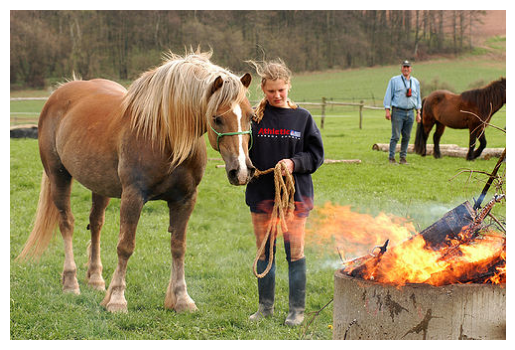

In [ ]:
IMG_PATH = "/content/drive/My Drive/Images/"
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
#cv2 reads image in BGR format so converting into RGB format
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

## Data Cleaning

In [ ]:
#function to clean the text
import re
def clean_text(sentence):
    #converting to lowercase
    sentence = sentence.lower()

    #re(regular expression) is replacing every non alphabet with a space
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()

    #remove all words of length one or random useless symbols
    sentence  = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

#not removing stopwords(a,an,the) and not performing stemming(running to run) as the model will also learn that way and proper english will not be generated.

In [ ]:
clean_text("A cat is sitting over the house # 64")

'cat is sitting over the house'

In [ ]:
#clean all captions
#.items() help to iterate over all key-value pairs
for key,caption_list in descriptions.items():
    #iterate over all the captions present in the list of a particular image-id
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [ ]:
descriptions["1000268201_693b08cb0e"]

['blonde horse and blonde girl in black sweatshirt are staring at fire in barrel',
 'girl and her horse stand by fire',
 'girl holding horse lead behind fire',
 'man and girl and two horses are near contained fire',
 'two people and two horses watching fire']

In [ ]:
#save all the data in a text file(since the file does not exist, a new file will be created)
with open("descriptions_1.txt","w") as f:
    #save the dictionary in the form of strings
    f.write(str(descriptions))

# Creating Vocabulary

In [ ]:
#creating a vocab -> which will be a set of unique words which the model can create
import json
descriptions = None
#open the file already created earlier
with open("descriptions_1.txt",'r') as f:
    descriptions= f.read()

#java-script-object-notation(json)
#converts the string into accepted format
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [ ]:
print(type(descriptions))

<class 'dict'>


In [ ]:
#set is used as it stores all the unique words
vocab = set()
for key in descriptions.keys():
    #for every sentence matched with the particular key, split that sentence into words and finally update vocab
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


In [ ]:
total_words = []
# forms a list of all the words present in all the captions of all images
for key in descriptions.keys():
    # iterating over all the captions of all keys and splitting into words and finally adding all in list
    [total_words.append(i) for des in descriptions[key] for i in des.split()]

print("Total Words %d"%len(total_words))

Total Words 373837


In [ ]:
print(total_words[:20])

['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', 'girl', 'going', 'into', 'wooden', 'building', 'little']


In [ ]:
import collections
#counts number of times each unique word occurs
counter = collections.Counter(total_words)

#converts into an dictionary
freq_cnt = dict(counter)

#len should be same as number of unique words
print(len(freq_cnt.keys()))

8424


In [ ]:
#sort this dictionary according to the frequency count in descending order, where comparision is to be done on the basis of number x[1]
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

threshold = 10

#filter words with higher frequency
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]

#creates a new list having unique words greater than frequency 10
total_words = [x[0] for x in sorted_freq_cnt]

In [ ]:
print(len(total_words))

1845


# Prepare train/ test data

In [ ]:
#read both files using the function created earlier
train_file_data = readTextFile("/content/drive/My Drive/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("/content/drive/My Drive/Flickr_TextData/Flickr_8k.testImages.txt")

In [ ]:
# print(test_file_data)

3385593926_d3e9c21170.jpg
2677656448_6b7e7702af.jpg
311146855_0b65fdb169.jpg
1258913059_07c613f7ff.jpg
241347760_d44c8d3a01.jpg
2654514044_a70a6e2c21.jpg
2339106348_2df90aa6a9.jpg
256085101_2c2617c5d0.jpg
280706862_14c30d734a.jpg
3072172967_630e9c69d0.jpg
3482062809_3b694322c4.jpg
1167669558_87a8a467d6.jpg
2847615962_c330bded6e.jpg
3344233740_c010378da7.jpg
2435685480_a79d42e564.jpg
3110649716_c17e14670e.jpg
2511019188_ca71775f2d.jpg
2521770311_3086ca90de.jpg
2723477522_d89f5ac62b.jpg
2218609886_892dcd6915.jpg
3745451546_fc8ec70cbd.jpg
2844018783_524b08e5aa.jpg
3100251515_c68027cc22.jpg
2207244634_1db1a1890b.jpg
2943023421_e297f05e11.jpg
3286822339_5535af6b93.jpg
2479652566_8f9fac8af5.jpg
1394368714_3bc7c19969.jpg
872622575_ba1d3632cc.jpg
2309860995_c2e2a0feeb.jpg
241347204_007d83e252.jpg
3502343542_f9b46688e5.jpg
757332692_6866ae545c.jpg
2748729903_3c7c920c4d.jpg
494792770_2c5f767ac0.jpg
3213992947_3f3f967a9f.jpg
2295750198_6d152d7ceb.jpg
2358898017_24496b80e8.jpg
3222055946_45f7293bb

In [ ]:
#split all the id's from \n except the last one which is null
#also splitting the id's from . and taking the 0th index part
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [ ]:
test[:5]

['3385593926_d3e9c21170',
 '2677656448_6b7e7702af',
 '311146855_0b65fdb169',
 '1258913059_07c613f7ff',
 '241347760_d44c8d3a01']

In [ ]:
#prepare desciptions for the training data
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:

        #startseq and endseq are two tokens which are added so that the model recognizes where the caption start and where it ends
        cap_to_append = "startseq "  + cap + " endseq"

        #newly formed caption is added to its corresponding image-id
        train_descriptions[img_id].append(cap_to_append)

In [ ]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

### Tranfer Learning

In [ ]:
#resnet50 is a pretrained model on imagenet dataset for image classification tasks which has 50 layers
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

#defines the shape of all the input images(ht,width, rgb color format)
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
#once we pass our model here it will have 2048 numbers as output
model.layers[-2].output

<KerasTensor shape=(None, 2048), dtype=float32, sparse=False, name=keras_tensor_175>

In [ ]:
#creates a new model which takes original resnet50 model but outputs the features from the second to last layer
model_new = Model(model.input,model.layers[-2].output)

In [ ]:
from tensorflow.keras.preprocessing import image
#extract image feature vectors for all images
def preprocess_img(img):
    #takes images and resizes into 224X224 px (as resnet50 expects it to be in this format)
    img = image.load_img(img,target_size=(224,224))

    #converts image into its corresponding array
    img = image.img_to_array(img)

    #used to expand the dimensions of image so that it can be passed through resnet50
    img = np.expand_dims(img,axis=0)

    #normalisation -> scales the pixel values to the range expected by resnet50
    img = preprocess_input(img)
    return img

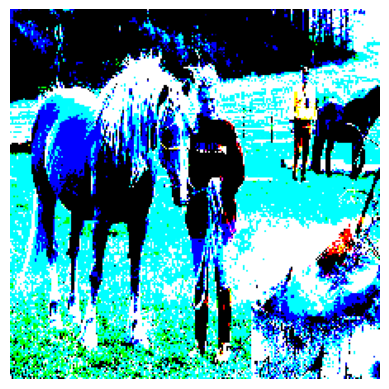

[[[[ -17.939003   -15.778999     3.3199997]
   [ -15.939003   -13.778999     5.3199997]
   [ -19.939003   -18.779        2.3199997]
   ...
   [  32.060997    42.221       81.32     ]
   [  34.060997    41.221       82.32     ]
   [  32.060997    39.221       80.32     ]]

  [[ -12.939003   -10.778999     8.32     ]
   [ -11.939003    -9.778999     9.32     ]
   [ -21.939003   -19.779       -0.6800003]
   ...
   [  34.060997    44.221       83.32     ]
   [  35.060997    42.221       82.32     ]
   [  34.060997    41.221       81.32     ]]

  [[ -13.939003   -11.778999     7.3199997]
   [ -11.939003    -9.778999     9.32     ]
   [ -26.939003   -23.779       -7.6800003]
   ...
   [  34.060997    44.221       83.32     ]
   [  34.060997    41.221       81.32     ]
   [  34.060997    41.221       81.32     ]]

  ...

  [[ -18.939003    42.221       17.32     ]
   [-103.939      -93.779     -114.68     ]
   [ -14.939003    58.221       39.32     ]
   ...
   [ -43.939003   -26.779       -4.

In [ ]:
img= preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()
#print(img)

In [ ]:
#function to accept an image, pass through the model and create a vector
def encode_image(img):
    #forms an array of the image and passes through the modified resnet50 model
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)

    #reshapes the vector to 1-d
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [ ]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([0.07437162, 1.4239492 , 0.44425187, ..., 1.202434  , 1.1954149 ,
       0.11512578], dtype=float32)

In [37]:
# the complete code is used to pass all the train images and save the vectors into a pkl file(python pickel file)
# since the number of images were large we divided into batches

# import pickle
# import numpy as np
# import os

# # Function to save encodings
# def save_encodings(encodings, file_path):
#     with open(file_path, 'wb') as file:
#         pickle.dump(encodings, file)
#     print(f"Encodings saved to {file_path}")

# # Batch processing
# batch_size = 1000
# num_batches = len(train) // batch_size + 1

# for batch_num in range(num_batches):
#     start_idx = batch_num * batch_size
#     end_idx = min((batch_num + 1) * batch_size, len(train))

#     encoding_batch = {}

#     for ix in range(start_idx, end_idx):
#         img_id = train[ix]
#         img_path = IMG_PATH + "/" + img_id + ".jpg"
#         encoding_batch[img_id] = encode_image(img_path)

#         if ix % 100 == 0:
#             print(f"Encoding in Progress - Image {ix}")

#     # Save each batch of encodings
#     batch_file_path = f"train_image_encodings_batch_{batch_num}.pkl"
#     save_encodings(encoding_batch, batch_file_path)

# print("All batches processed and saved.")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Encoding in Progress - Image 3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━

In [ ]:
# the complete code is used to pass all the test images and save the vectors into a pkl file(python pickel file)


# import pickle
# import numpy as np
# import os

# # Function to save encodings
# def save_encodings(encodings, file_path):
#     with open(file_path, 'wb') as file:
#         pickle.dump(encodings, file)
#     print(f"Encodings saved to {file_path}")

# start = time()
# encoding_test = {}
# #image_id -->feature_vector extracted from Resnet Image

# for ix,img_id in enumerate(test):
#     img_path = IMG_PATH+"/"+img_id+".jpg"
#     encoding_test[img_id] = encode_image(img_path)

#     if ix%100==0:
#         print("Test Encoding in Progress Time step %d "%ix)

# end_t = time()
# print("Total Time Taken(test) :",end_t-start)
# save_encodings(encoding_test, "test_image_encodings.pkl")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Test Encoding in Progress Time step 0 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━

## Data preprocessing

In [38]:
#vocab formed
len(total_words)

1845

In [39]:
word_to_idx = {}
idx_to_word = {}

#mapping each word with a particular index, reserving 0th index for padding in sequences
for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [40]:
print(len(idx_to_word))

1845


In [41]:
#adding two special words startseq and endseq

idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [42]:
#finding maximum length sentence so that it can be the batch size

max_len = 0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))

print(max_len)


35


## data loader(Generator)

In [46]:
#combining all the pkl train batch files into one pkl file

import pickle
import os

#list of .pkl files
pkl_files = [
    "/content/drive/MyDrive/pkl files/train_image_encodings_batch_0.pkl",
    "/content/drive/MyDrive/pkl files/train_image_encodings_batch_1.pkl",
    "/content/drive/MyDrive/pkl files/train_image_encodings_batch_2.pkl",
    "/content/drive/MyDrive/pkl files/train_image_encodings_batch_3.pkl",
    "/content/drive/MyDrive/pkl files/train_image_encodings_batch_4.pkl",
    "/content/drive/MyDrive/pkl files/train_image_encodings_batch_5.pkl"
]

#initialize an empty dictionary to hold all encodings
combined_encodings = {}

#load and combine encodings from each .pkl file
for pkl_file in pkl_files:
    with open(pkl_file, 'rb') as file:
        encodings = pickle.load(file)
        combined_encodings.update(encodings)

#save the combined encodings into a single .pkl file
combined_pkl_file = "combined_train_image_encodings.pkl"
with open(combined_pkl_file, 'wb') as file:
    pickle.dump(combined_encodings, file)

print(f"Combined encodings saved to {combined_pkl_file}")


Combined encodings saved to combined_train_image_encodings.pkl


In [47]:
def load_encodings(file_path):
    with open(file_path, 'rb') as file:
        encodings = pickle.load(file)
    print(f"Encodings loaded from {file_path}")
    return encodings

#load the saved encodings
encoding_train = load_encodings("/content/drive/MyDrive/encodings/train_image_encodings.pkl")
encoding_test = load_encodings("/content/drive/MyDrive/encodings/test_image_encodings.pkl")

Encodings loaded from /content/drive/MyDrive/encodings/train_image_encodings.pkl
Encodings loaded from /content/drive/MyDrive/encodings/test_image_encodings.pkl


In [48]:
from keras.utils import to_categorical
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]

    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1

            photo = encoding_train[key]
            for desc in desc_list:

                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]

                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)

                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

## word embedding

In [49]:
f = open("/content/drive/My Drive/glove.6B.50d.txt",encoding='utf8')

In [50]:
embedding_index = {}

for line in f:
    values = line.split()

    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding


In [51]:
f.close()

In [52]:

embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [53]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)

        if embedding_vector is not None:
            matrix[idx] = embedding_vector

    return matrix

In [54]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [55]:
embedding_matrix[1847]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Model Architecture

In [56]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [57]:
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [58]:

decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [59]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 35)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 35, 50)         │         92,400 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 2048)           │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 35, 50)         │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 35)             │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        524,544 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        314,368 │ dropout_1[0][0],       │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dense[0][0],           │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         65,792 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1848)           │        474,936 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,472,040 (5.62 MB)

 Trainable params: 1,472,040 (5.62 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [61]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

### Training of model

In [65]:
epochs = 10
batch_size = 3
steps = len(train_descriptions)//batch_size

In [66]:
for i in range(epochs):
    generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_'+str(i)+'.h5')
    print("Epoch %d saved! "%i)

ValueError: When passing a Python generator to a Keras model, the generator must return a tuple, either (input,) or (inputs, targets) or (inputs, targets, sample_weights). Received: [[array([[0.34707963, 0.5115918 , 0.08728839, ..., 1.1897293 , 0.04043848,
        0.15271065],
       [0.34707963, 0.5115918 , 0.08728839, ..., 1.1897293 , 0.04043848,
        0.15271065],
       [0.34707963, 0.5115918 , 0.08728839, ..., 1.1897293 , 0.04043848,
        0.15271065],
       ...,
       [0.7674451 , 0.5342262 , 0.38325158, ..., 0.02098689, 0.18429324,
        0.0427001 ],
       [0.7674451 , 0.5342262 , 0.38325158, ..., 0.02098689, 0.18429324,
        0.0427001 ],
       [0.7674451 , 0.5342262 , 0.38325158, ..., 0.02098689, 0.18429324,
        0.0427001 ]], dtype=float32), array([[1846,    0,    0, ...,    0,    0,    0],
       [1846,   12,    0, ...,    0,    0,    0],
       [1846,   12,    6, ...,    0,    0,    0],
       ...,
       [1846,   24,    6, ...,    0,    0,    0],
       [1846,   24,    6, ...,    0,    0,    0],
       [1846,   24,    6, ...,    0,    0,    0]], dtype=int32)], array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])]